# Age, Gender & Expression Recognizer

## 1. Setup and Preparation

### 1.1 Import Libraries and Setting Up Device-agnostic code

In [1]:
import torch
import pandas as pd
import random

from torch import nn
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

torch.__version__

'2.4.1+cu121'

In [2]:
# Setting device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### 1.2 Configuration

In [3]:
data_path = Path('/kaggle/input/')

AGE_FILE_PATH = data_path / 'facial-age'
EMOTION_FILE_PATH = data_path / 'facial-emotion-dataset'
GENDER_FILE_PATH = data_path / 'biggest-genderface-recognition-dataset'

In [4]:
AGE_FILE_PATH, EMOTION_FILE_PATH, GENDER_FILE_PATH

(PosixPath('/kaggle/input/facial-age'),
 PosixPath('/kaggle/input/facial-emotion-dataset'),
 PosixPath('/kaggle/input/biggest-genderface-recognition-dataset'))

### 1.3 Load Datasets

In [5]:
import os

def walk_throuhg_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

In [6]:
# walk_throuhg_dir(AGE_FILE_PATH)

In [7]:
# walk_throuhg_dir(EMOTION_FILE_PATH)

In [8]:
walk_throuhg_dir(GENDER_FILE_PATH)

There are 1 directories and 0 images in /kaggle/input/biggest-genderface-recognition-dataset
There are 2 directories and 0 images in /kaggle/input/biggest-genderface-recognition-dataset/faces
There are 0 directories and 17678 images in /kaggle/input/biggest-genderface-recognition-dataset/faces/man
There are 0 directories and 9489 images in /kaggle/input/biggest-genderface-recognition-dataset/faces/woman


## 2. Data Exploration and Preprocessing

In [9]:
def convert_to_df(data_path, name_category):
    paths = [path for path in data_path.rglob('*/*') if path.suffix.lower() in ['.jpg', '.png']]

    # Create the DataFrame with relevant columns
    df = pd.DataFrame({
        'file_path': paths,
        'file_name': [path.name for path in paths],  # Extract file name
         name_category: [path.parts[-2] for path in paths]  # Extract folder name as label
    })
    return df

In [10]:
# Age Dataset
age_df = convert_to_df(AGE_FILE_PATH, name_category='age')
print(age_df.head())

# Gender Dataset
gender_df = convert_to_df(GENDER_FILE_PATH, name_category='gender')
print(gender_df.head())

# Emotion Dataset
emotion_df = convert_to_df(EMOTION_FILE_PATH, name_category='emotion')
emotion_df.head()

                                        file_path file_name  age
0  /kaggle/input/facial-age/face_age/057/6802.png  6802.png  057
1  /kaggle/input/facial-age/face_age/057/3702.png  3702.png  057
2  /kaggle/input/facial-age/face_age/057/8810.png  8810.png  057
3  /kaggle/input/facial-age/face_age/057/6759.png  6759.png  057
4  /kaggle/input/facial-age/face_age/057/1846.png  1846.png  057
                                           file_path      file_name gender
0  /kaggle/input/biggest-genderface-recognition-d...   man_4160.jpg    man
1  /kaggle/input/biggest-genderface-recognition-d...  man_16738.jpg    man
2  /kaggle/input/biggest-genderface-recognition-d...   man_4001.jpg    man
3  /kaggle/input/biggest-genderface-recognition-d...   man_4435.jpg    man
4  /kaggle/input/biggest-genderface-recognition-d...  man_12722.jpg    man


,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.269276~12fffff.png,Surprise
1,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.264079~12fffff.png,Surprise
2,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.260019~12fffff.png,Surprise
3,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.267910~12fffff.png,Surprise
4,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.414980~12fffff.png,Surprise


In [11]:
emotion_df['file_path'][0]

PosixPath('/kaggle/input/facial-emotion-dataset/facial_emotion_dataset/dataset/Surprise/cropped_emotions.269276~12fffff.png')

In [12]:
age_df.shape, gender_df.shape, emotion_df.shape

((19556, 3), (27167, 3), (15232, 3))

In [13]:
# Droping duplicated values in age dataset
print(age_df.duplicated(['file_name', 'age']).sum())
age_df.drop_duplicates(['file_name', 'age'], inplace=True)

# Droping duplicated values in gender dataset
print(gender_df.duplicated(['file_name', 'gender']).sum())
gender_df.drop_duplicates(['file_name', 'gender'], inplace=True)

# Droping duplicated values in train emotion dataset
print(emotion_df.duplicated(['file_name', 'emotion']).sum())
emotion_df.drop_duplicates(['file_name', 'emotion'], inplace=True)

9778
0
0


In [14]:
emotion_df['emotion'].value_counts()

emotion
Neutral     3945
Sad         3875
Happy       3673
Angry       1303
Surprise    1231
Ahegao      1205
Name: count, dtype: int64

In [15]:
age_df.shape, gender_df.shape

((9778, 3), (27167, 3))

In [16]:
# Define bins and labels
age_bins = [0, 3, 12, 18, 55, 70]
age_labels = ['Baby', 'Child', 'Teen', 'Adult', 'Elderly']

age_idx = {label:i for i, label in enumerate(age_labels)}
print(age_idx)

# Assign age categories based on bins
age_df['age_category'] = pd.cut(age_df['age'].astype(int), bins=age_bins, labels=age_labels, right=False)
age_df.head()

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Adult': 3, 'Elderly': 4}


,file_path,file_name,age,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,6802.png,057,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,3702.png,057,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,8810.png,057,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,6759.png,057,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,1846.png,057,Elderly


In [17]:
gender_df['gender'] = gender_df['gender'].str.lower()
gender_df.head()

,file_path,file_name,gender
0,/kaggle/input/biggest-genderface-recognition-d...,man_4160.jpg,man
1,/kaggle/input/biggest-genderface-recognition-d...,man_16738.jpg,man
2,/kaggle/input/biggest-genderface-recognition-d...,man_4001.jpg,man
3,/kaggle/input/biggest-genderface-recognition-d...,man_4435.jpg,man
4,/kaggle/input/biggest-genderface-recognition-d...,man_12722.jpg,man


In [18]:
print(age_df.isnull().sum())
age_df.dropna(inplace=True)

print(gender_df.isnull().sum())
gender_df.dropna(inplace=True)

print(emotion_df.isnull().sum())
emotion_df.dropna(inplace=True)

file_path         0
file_name         0
age               0
age_category    794
dtype: int64
file_path    0
file_name    0
gender       0
dtype: int64
file_path    0
file_name    0
emotion      0
dtype: int64


In [19]:
emotion_df.drop(emotion_df[emotion_df['emotion'] == 'Ahegao'].index, inplace=True)
print(emotion_df.shape)
emotion_df.head()

(14027, 3)


,file_path,file_name,emotion
0,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.269276~12fffff.png,Surprise
1,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.264079~12fffff.png,Surprise
2,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.260019~12fffff.png,Surprise
3,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.267910~12fffff.png,Surprise
4,/kaggle/input/facial-emotion-dataset/facial_em...,cropped_emotions.414980~12fffff.png,Surprise


In [20]:
age_df.drop(['age', 'file_name'], axis=1, inplace=True)
print(age_df.shape)
age_df.head()

(8984, 2)


,file_path,age_category
0,/kaggle/input/facial-age/face_age/057/6802.png,Elderly
1,/kaggle/input/facial-age/face_age/057/3702.png,Elderly
2,/kaggle/input/facial-age/face_age/057/8810.png,Elderly
3,/kaggle/input/facial-age/face_age/057/6759.png,Elderly
4,/kaggle/input/facial-age/face_age/057/1846.png,Elderly


In [21]:
gender_df.drop('file_name', axis=1, inplace=True)
emotion_df.drop('file_name', axis=1, inplace=True)

In [22]:
gender_df.head()

,file_path,gender
0,/kaggle/input/biggest-genderface-recognition-d...,man
1,/kaggle/input/biggest-genderface-recognition-d...,man
2,/kaggle/input/biggest-genderface-recognition-d...,man
3,/kaggle/input/biggest-genderface-recognition-d...,man
4,/kaggle/input/biggest-genderface-recognition-d...,man


In [23]:
emotion_df.head()

,file_path,emotion
0,/kaggle/input/facial-emotion-dataset/facial_em...,Surprise
1,/kaggle/input/facial-emotion-dataset/facial_em...,Surprise
2,/kaggle/input/facial-emotion-dataset/facial_em...,Surprise
3,/kaggle/input/facial-emotion-dataset/facial_em...,Surprise
4,/kaggle/input/facial-emotion-dataset/facial_em...,Surprise


In [24]:
emotion_df['emotion'].value_counts()

emotion
Neutral     3945
Sad         3875
Happy       3673
Angry       1303
Surprise    1231
Name: count, dtype: int64

In [25]:
age_df['age_category'].value_counts()

age_category
Adult      4004
Baby       1587
Child      1562
Elderly    1055
Teen        776
Name: count, dtype: int64

In [26]:
gender_df['gender'].value_counts()

gender
man      17678
woman     9489
Name: count, dtype: int64

### EDA - Exploratory Data Analysis

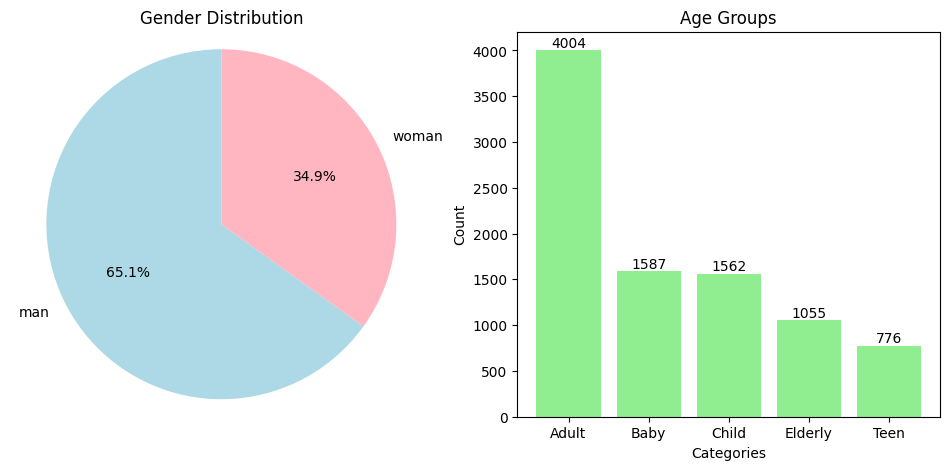

In [27]:
import matplotlib.pyplot as plt

# Age Info
age_dict = dict(age_df['age_category'].value_counts())
age_names = list(age_dict.keys())
age_count = list(age_dict.values())

# Gender Info
gender_dict = dict(gender_df['gender'].value_counts())
gender_names = list(gender_dict.keys())
gender_count = list(gender_dict.values())

# Create 1x2 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart for Age
axs[1].bar(age_names, age_count, color='lightgreen')
axs[1].set_title('Age Groups')
axs[1].set_xlabel('Categories')
axs[1].set_ylabel('Count')

# Add text labels on bars
for i, count in enumerate(age_count):
    axs[1].text(i, count + 1, str(count), ha='center', va='bottom')

# Pie Chart for Gender
axs[0].pie(
    gender_count,
    labels=gender_names,
    colors=['lightblue', 'lightpink'],
    autopct='%1.1f%%',
    startangle=90
)
axs[0].set_title('Gender Distribution')
axs[0].axis('equal')  # Make pie chart circular

plt.show()

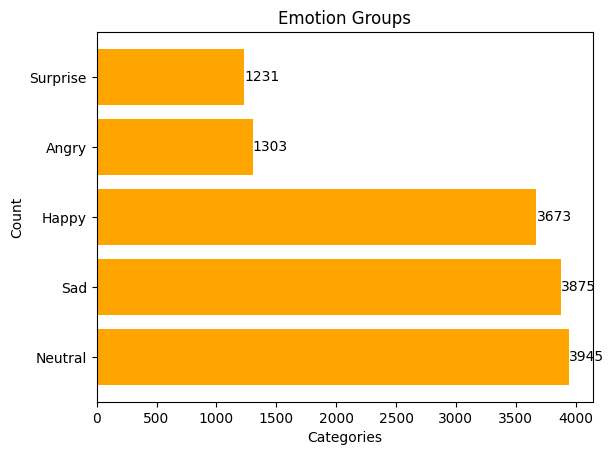

In [28]:
# Emotion Info
emotion_dict = dict(emotion_df['emotion'].value_counts())
emotion_names = list(emotion_dict.keys())
emotion_count = list(emotion_dict.values())

plt.barh(emotion_names, emotion_count, color='orange')

for i, count in enumerate(emotion_count):
    plt.text(count + 1, i, str(count), va='center')

plt.title('Emotion Groups')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

### Balancing Imbalanced Data

In [29]:
import pandas as pd
from sklearn.utils import resample

# Function to balance the dataset to have exactly 'n' samples per category
def balance_dataframe(dataframe, label_col, n):
    balanced_dfs = []
    for category, group in dataframe.groupby(label_col, observed=False):
        if len(group) >= n:
            balanced_dfs.append(group.sample(n=n, random_state=42))
        else:
            # Retain all samples if the group has fewer than 'n' samples
            balanced_dfs.append(group)
    
    return pd.concat(balanced_dfs).reset_index(drop=True)  # Convert list to DataFrame

In [30]:
# Apply function to balance the age dataset
age_balanced_df = balance_dataframe(dataframe=age_df, label_col='age_category', n=1100)

# Display the first few rows
print(age_balanced_df.head())
age_balanced_df['age_category'].value_counts()

                                        file_path age_category
0  /kaggle/input/facial-age/face_age/001/2080.png         Baby
1  /kaggle/input/facial-age/face_age/002/6050.png         Baby
2  /kaggle/input/facial-age/face_age/002/2680.png         Baby
3  /kaggle/input/facial-age/face_age/001/8335.png         Baby
4  /kaggle/input/facial-age/face_age/001/1266.png         Baby


age_category
Baby       1100
Child      1100
Adult      1100
Elderly    1055
Teen        776
Name: count, dtype: int64

In [31]:
# Apply function to balance the age dataset
gender_df = balance_dataframe(dataframe=gender_df, label_col='gender', n=3100)

# Display the first few rows
print(gender_df.head())
gender_df['gender'].value_counts()

                                           file_path gender
0  /kaggle/input/biggest-genderface-recognition-d...    man
1  /kaggle/input/biggest-genderface-recognition-d...    man
2  /kaggle/input/biggest-genderface-recognition-d...    man
3  /kaggle/input/biggest-genderface-recognition-d...    man
4  /kaggle/input/biggest-genderface-recognition-d...    man


gender
man      3100
woman    3100
Name: count, dtype: int64

In [32]:
# Apply function to balance the emotion dataset
emotion_data = balance_dataframe(dataframe=emotion_df, label_col='emotion', n=1300)

# Display the first few rows
print(emotion_data.head())
emotion_data['emotion'].value_counts()

                                           file_path emotion
0  /kaggle/input/facial-emotion-dataset/facial_em...   Angry
1  /kaggle/input/facial-emotion-dataset/facial_em...   Angry
2  /kaggle/input/facial-emotion-dataset/facial_em...   Angry
3  /kaggle/input/facial-emotion-dataset/facial_em...   Angry
4  /kaggle/input/facial-emotion-dataset/facial_em...   Angry


emotion
Angry       1300
Happy       1300
Neutral     1300
Sad         1300
Surprise    1231
Name: count, dtype: int64

In [33]:
train_age_data, test_age_data = train_test_split(age_balanced_df, shuffle=True, test_size=0.25)
print(train_age_data.head())

train_gender_data, test_gender_data = train_test_split(gender_df, shuffle=True, test_size=0.25)
print(train_gender_data.head())

train_emotion_data, test_emotion_data = train_test_split(emotion_data, shuffle=True, test_size=0.25)
print(train_emotion_data.head())

                                           file_path age_category
526   /kaggle/input/facial-age/face_age/001/3880.png         Baby
4163  /kaggle/input/facial-age/face_age/061/1383.png      Elderly
2062  /kaggle/input/facial-age/face_age/009/3375.png        Child
4353  /kaggle/input/facial-age/face_age/055/1443.png      Elderly
4661  /kaggle/input/facial-age/face_age/060/7975.png      Elderly
                                              file_path gender
5761  /kaggle/input/biggest-genderface-recognition-d...  woman
5412  /kaggle/input/biggest-genderface-recognition-d...  woman
1472  /kaggle/input/biggest-genderface-recognition-d...    man
2628  /kaggle/input/biggest-genderface-recognition-d...    man
797   /kaggle/input/biggest-genderface-recognition-d...    man
                                              file_path   emotion
5498  /kaggle/input/facial-emotion-dataset/facial_em...  Surprise
1223  /kaggle/input/facial-emotion-dataset/facial_em...     Angry
6242  /kaggle/input/facial-e

In [34]:
train_age_data.shape, test_age_data.shape

((3848, 2), (1283, 2))

In [35]:
train_gender_data.shape, test_gender_data.shape

((4650, 2), (1550, 2))

In [36]:
train_emotion_data.shape, test_emotion_data.shape

((4823, 2), (1608, 2))

In [37]:
age_idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Adult': 3, 'Elderly': 4}

In [38]:
print("Unique Age Labels:", age_df['age_category'].unique())
print("Unique Gender Labels:", gender_df['gender'].unique())
print("Unique Emotion Labels:", emotion_df['emotion'].unique())

Unique Age Labels: ['Elderly', 'Adult', 'Teen', 'Child', 'Baby']
Categories (5, object): ['Baby' < 'Child' < 'Teen' < 'Adult' < 'Elderly']
Unique Gender Labels: ['man' 'woman']
Unique Emotion Labels: ['Surprise' 'Angry' 'Neutral' 'Sad' 'Happy']


### Mini dataset for evaluation

In [39]:
age = test_age_data.groupby('age_category', observed=True)
gender = test_gender_data.groupby('gender')
emotion = test_emotion_data.groupby('emotion')

test_combined = pd.concat([age.head(), gender.head(), emotion.head()], axis=0)
test_combined.reset_index(inplace=True)
test_combined.head()

,index,file_path,age_category,gender,emotion
0,3115,/kaggle/input/facial-age/face_age/027/8960.png,Adult,NaN,NaN
1,1857,/kaggle/input/facial-age/face_age/009/1637.png,Child,NaN,NaN
2,3173,/kaggle/input/facial-age/face_age/051/7956.png,Adult,NaN,NaN
3,1125,/kaggle/input/facial-age/face_age/006/2615.png,Child,NaN,NaN
4,1661,/kaggle/input/facial-age/face_age/008/8607.png,Child,NaN,NaN


In [40]:
test_combined.shape

(60, 5)

In [41]:
test_combined['emotion'].unique()

array([nan, 'Surprise', 'Happy', 'Sad', 'Angry', 'Neutral'], dtype=object)

In [42]:
import os
import shutil
from PIL import Image

# Create a folder to save the images
output_folder = "test_images"
os.makedirs(output_folder, exist_ok=True)

# Loop through the rows and save the images
for i, row in test_combined.iterrows():
    img_path = row['file_path']
    img = Image.open(img_path)
    img.save(os.path.join(output_folder, f"image_{i}.jpg"))

In [43]:
from IPython.display import FileLink

shutil.make_archive('test_images', 'zip', 'selected_images')

# Create a clickable download link
FileLink(r'test_images.zip')

/kaggle/working/test_images.zip

In [44]:
# Deleting samples from test datasets

if 'index' in test_combined.columns:
    test_age_data = test_age_data[~test_age_data.index.isin(test_combined['index'])]
    test_gender_data = test_gender_data[~test_gender_data.index.isin(test_combined['index'])]
    test_emotion_data = test_emotion_data[~test_emotion_data.index.isin(test_combined['index'])]

In [45]:
train_age_data.shape, test_age_data.shape

((3848, 2), (1253, 2))

In [46]:
train_gender_data.shape, test_gender_data.shape

((4650, 2), (1526, 2))

In [47]:
train_emotion_data.shape, test_emotion_data.shape

((4823, 2), (1575, 2))

## 3. Data Transformation for All Dataset

In [48]:
# Define the transformation pipeline
train_transforms = transforms.Compose([
    # transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(128, 128)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    # transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize(size=(128, 128)),  
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transforms = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 4. Creating PyTorch Datasets

### 4.1 Creating Custom Dataset for All Data

In [49]:
import torch
from torch.utils.data import Dataset
from PIL import Image

import torch
from torch.utils.data import Dataset
from PIL import Image


class CombinedCustomDataset(Dataset):
    def __init__(self, age_data, gender_data, emotion_data, age_idx, gender_idx, emotion_idx, transform=None):
        """
        A combined dataset for Age, Gender, and Emotion classification.

        Args:
            age_data (pd.DataFrame): DataFrame containing Age dataset metadata (no gender info).
            gender_data (pd.DataFrame): DataFrame containing Gender dataset metadata.
            emotion_data (pd.DataFrame): DataFrame containing Emotion dataset metadata.
            age_idx (dict): Dictionary mapping age categories to indices.
            gender_idx (dict): Dictionary mapping gender labels to indices.
            emotion_idx (dict): Dictionary mapping emotion labels to indices.
            transform (callable, optional): Image transformations for preprocessing.
        """
        self.age_df = age_data
        self.gender_df = gender_data
        self.emotion_df = emotion_data

        self.age_idx = age_idx
        self.gender_idx = gender_idx
        self.emotion_idx = emotion_idx

        self.transform = transform
        self.total_size = len(self.age_df) + len(self.gender_df) + len(self.emotion_df)

    def __len__(self):
        return self.total_size

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding labels (age, gender, emotion).
        If a label is missing for a specific dataset, it is set to -1.
        """
        if idx < len(self.age_df):  # Age dataset
            row = self.age_df.iloc[idx]
            image = Image.open(str(row['file_path']))
            label = [
                self.age_idx.get(row['age_category'], -1),  
                -1,  
                -1   
            ]
        
        elif idx < len(self.age_df) + len(self.gender_df):  # Gender dataset
            row = self.gender_df.iloc[idx - len(self.age_df)]
            image = Image.open(str(row['file_path']))
            label = [
                -1,  
                self.gender_idx.get(row['gender'], -1),  
                -1  
            ]

        else:  # Emotion dataset
            row = self.emotion_df.iloc[idx - (len(self.age_df) + len(self.gender_df))]
            image = Image.open(str(row['file_path']))
            label = [
                -1,  
                -1,  
                self.emotion_idx.get(row['emotion'], -1)  
            ]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [50]:
gender_labels = list(train_gender_data['gender'].unique())
gender_idx = {label:i for i, label in enumerate(gender_labels)}

gender_idx

{'woman': 0, 'man': 1}

In [51]:
emotion_labels = list(train_emotion_data['emotion'].unique())
emotion_idx = {label:i for i, label in enumerate(emotion_labels)}

emotion_idx

{'Surprise': 0, 'Angry': 1, 'Happy': 2, 'Sad': 3, 'Neutral': 4}

In [52]:
age_idx

{'Baby': 0, 'Child': 1, 'Teen': 2, 'Adult': 3, 'Elderly': 4}

In [53]:
train_combined_dataset =  CombinedCustomDataset(age_data=train_age_data, 
                                                gender_data=train_gender_data, 
                                                emotion_data=train_emotion_data, 
                                                age_idx=age_idx, 
                                                gender_idx=gender_idx, 
                                                emotion_idx=emotion_idx, 
                                                transform=train_transforms)

In [54]:
test_combined_dataset =  CombinedCustomDataset(age_data=test_age_data, 
                                                gender_data=test_gender_data, 
                                                emotion_data=test_emotion_data, 
                                                age_idx=age_idx, 
                                                gender_idx=gender_idx, 
                                                emotion_idx=emotion_idx, 
                                                transform=test_transforms)

In [55]:
train_combined_dataset.total_size

13321

In [56]:
test_combined_dataset.total_size

4354

In [57]:
train_combined_dataset.age_idx, train_combined_dataset.gender_idx, train_combined_dataset.emotion_idx,

({'Baby': 0, 'Child': 1, 'Teen': 2, 'Adult': 3, 'Elderly': 4},
 {'woman': 0, 'man': 1},
 {'Surprise': 0, 'Angry': 1, 'Happy': 2, 'Sad': 3, 'Neutral': 4})

In [58]:
# Test the training dataset
img, label_idx = train_combined_dataset[0]
print(f"Image size: {img.size()}, Label index: {label_idx}")

Image size: torch.Size([3, 128, 128]), Label index: tensor([ 0, -1, -1])


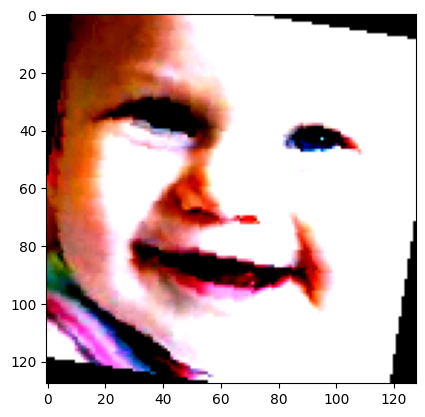

In [59]:
plt.imshow(train_combined_dataset[0][0].permute(1, 2, 0))

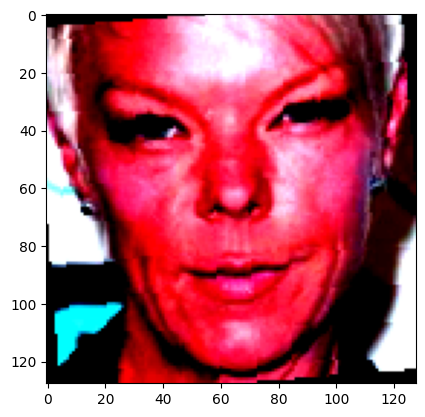

In [60]:
plt.imshow(train_combined_dataset[4][0].permute(1, 2, 0))

In [61]:
import matplotlib.pyplot as plt
import torch
import random

# Adjusted display_random_images function for multi-task dataset
def display_random_images(dataset, age_classes=None, gender_classes=None, 
                          emotion_classes=None, n=10, display_shape=True, seed=None):
    if n > 10:
        n = 10
        display_shape = False
        print("n should NOT be larger than 10")

    if seed:
        random.seed(seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, idx in enumerate(random_samples_idx):
        img_tensor, labels = dataset[idx]
        
        # Convert image tensor to numpy (PyTorch format -> Matplotlib format)
        img_np = img_tensor.permute(1, 2, 0).numpy()

        # Extract labels (age, gender, emotion)
        age_label, gender_label, emotion_label = labels.tolist()

        # Format labels correctly
        age_text = f"Age: {age_classes[age_label]}" if (age_classes and age_label != -1) else "Age: N/A"
        gender_text = f"Gender: {gender_classes[gender_label]}" if (gender_classes and gender_label != -1) else "Gender: N/A"
        emotion_text = f"Emotion: {emotion_classes[emotion_label]}" if (emotion_classes and emotion_label != -1) else "Emotion: N/A"

        # Plot image
        plt.subplot(1, n, i + 1)
        plt.imshow(img_np)
        plt.axis("off")

        # Display labels & shape info
        title = f"{age_text}\n{gender_text}\n{emotion_text}"
        if display_shape:
            title += f"\nShape: {img_tensor.shape}"
        plt.title(title, fontsize=10)

    plt.show()

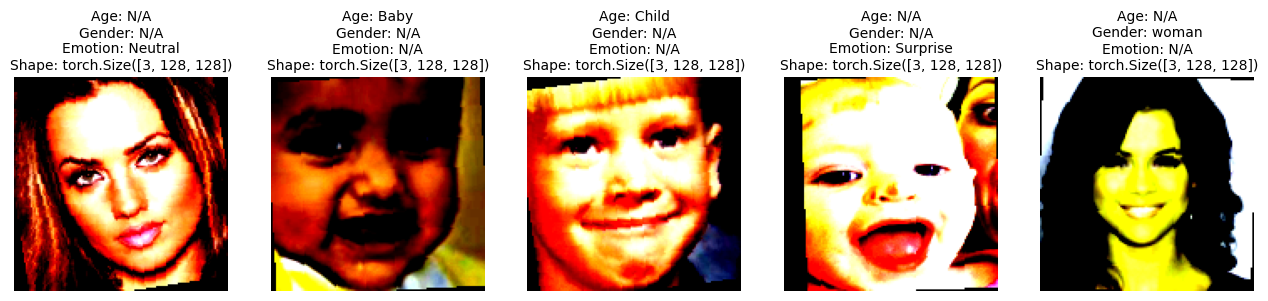

In [62]:
# Call function
display_random_images(
    dataset=train_combined_dataset,
    age_classes=age_labels,
    gender_classes=gender_labels,
    emotion_classes=emotion_labels,
    n=5,  # Display 5 images
    seed=42  # Random seed for reproducibility
)

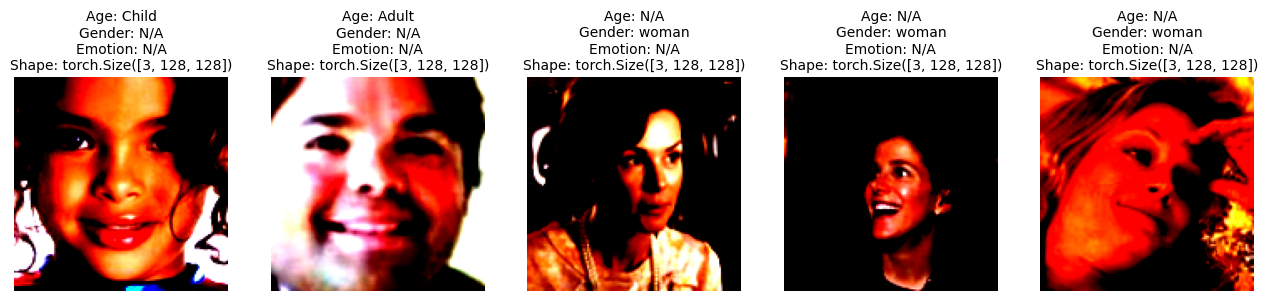

In [63]:
# Call function
display_random_images(
    dataset=test_combined_dataset,
    age_classes=age_labels,
    gender_classes=gender_labels,
    emotion_classes=emotion_labels,
    n=5,  # Display 5 images
    seed=42  # Random seed for reproducibility
)

## 5. Turn all Dataset into DataLoader

In [64]:
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)

# Age Dataset
train_dataloader = DataLoader(dataset=train_combined_dataset, 
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_combined_dataset, 
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [65]:
train_images, train_labels = next(iter(train_dataloader))
train_images.shape, train_labels.shape, train_labels[:10]

(torch.Size([32, 3, 128, 128]),
 torch.Size([32, 3]),
 tensor([[ 2, -1, -1],
         [-1, -1,  1],
         [-1, -1,  4],
         [ 0, -1, -1],
         [-1, -1,  1],
         [-1,  1, -1],
         [-1,  0, -1],
         [ 2, -1, -1],
         [ 3, -1, -1],
         [-1, -1,  2]]))

In [66]:
len(train_dataloader), len(test_dataloader)

(417, 137)

In [67]:
for batch in train_dataloader:
    X, y = batch
    print("Unique Labels in Dataset:", y.unique())
    break  # Print labels and exit loop

Unique Labels in Dataset: tensor([-1,  0,  1,  2,  3,  4])


## 6. Model Architecture 

In [68]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiTaskEfficientNetV2(nn.Module):
    def __init__(self, input_shape, hidden_shape, num_age_classes, 
                 num_gender_classes, num_emotion_classes):
        
        super(MultiTaskEfficientNetV2, self).__init__()
        
        # Load EfficientNetV2 backbone (pretrained on ImageNet)
        backbone = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
        self.shared_backbone = nn.Sequential(
            *list(backbone.children())[:-1],
            
        ) # Remove the classification head
        
        
        # Define task-specific heads
        self.age_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_shape, 256),
            nn.ReLU(),
            nn.Linear(256, num_age_classes),
        )
        
        self.gender_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_shape, 256),
            nn.ReLU(),
            nn.Linear(256, num_gender_classes),
        )
        
        self.emotion_head = nn.Sequential(
            nn.Linear(input_shape, hidden_shape),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_shape, 256),
            nn.ReLU(),
            nn.Linear(256, num_emotion_classes),
        )
        
    def forward(self, x):
        features = self.shared_backbone(x)        # Extract shared features
        features = torch.flatten(features, 1)
        age_out = self.age_head(features)
        gender_out = self.gender_head(features)
        emotion_out = self.emotion_head(features)
        
        return age_out, gender_out, emotion_out

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 7. Model Training

In [70]:
def train_step(model, dataloader, age_loss_fn, 
               gender_loss_fn, emotion_loss_fn,
               optimizer, device=device):

    """
    Perform a single training step for each epoch.

    Parameters:
        model: PyTorch multi-task model.
        dataloader: DataLoader for training data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for age, gender, and emotion tasks.
        optimizer: Optimizer to update the model parameters.
        device: Device for computation (e.g., "cpu" or "cuda").

    Returns:
        train_loss: Average loss over the epoch.
        train_acc: Average accuracy across all tasks.
        overall_accuracy: Dictionary of task-specific accuracies.
    """

    model.train()
    train_loss = 0
    age_acc, gender_acc, emotion_acc = 0, 0, 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward pass
        age_pred, gender_pred, emotion_pred = model(X)
    
        # Initialize accumulators
        num_tasks = 0
        batch_loss = 0
    
        # Calculate Age Loss
        age_indices = y[:, 0] != -1
        if age_indices.sum() > 0:
            age_loss = age_loss_fn(age_pred[age_indices], y[age_indices, 0].long())
            batch_loss += age_loss
            num_tasks += 1
    
            # Calculate Age Accuracy
            age_pred_class = age_pred.argmax(dim=1)
            age_accuracy = (age_pred_class[age_indices] == y[age_indices, 0]).sum().item() / age_indices.sum().item()
            age_acc += age_accuracy
    
        # Calculate Gender Loss
        gender_indices = y[:, 1] != -1
        if gender_indices.sum() > 0:
            gender_loss = gender_loss_fn(gender_pred[gender_indices], y[gender_indices, 1].long())
            batch_loss += gender_loss
            num_tasks += 1
    
            # Calculate Gender Accuracy
            gender_pred_class = gender_pred.argmax(dim=1)
            gender_accuracy = (gender_pred_class[gender_indices] == y[gender_indices, 1]).sum().item() / gender_indices.sum().item()
            gender_acc += gender_accuracy
    
        # Calculate Emotion Loss
        emotion_indices = y[:, 2] != -1
        if emotion_indices.sum() > 0:
            emotion_loss = emotion_loss_fn(emotion_pred[emotion_indices], y[emotion_indices, 2].long())
            batch_loss += emotion_loss
            num_tasks += 1
    
            # Calculate Emotion Accuracy
            emotion_pred_class = emotion_pred.argmax(dim=1)
            emotion_accuracy = (emotion_pred_class[emotion_indices] == y[emotion_indices, 2]).sum().item() / emotion_indices.sum().item()
            emotion_acc += emotion_accuracy

        # Backpropagation
        optimizer.zero_grad()
        if num_tasks > 0:  # Avoid division by zero
            batch_loss = batch_loss / num_tasks
            train_loss += batch_loss.item()
            batch_loss.backward()
            optimizer.step()

    # Average Loss and Accuracy
    train_loss /= num_batches
    avg_age_acc = age_acc / num_batches
    avg_gender_acc = gender_acc / num_batches
    avg_emotion_acc = emotion_acc / num_batches
    train_acc = (avg_age_acc + avg_gender_acc + avg_emotion_acc) / 3

    accuracy_info = {
        "Age Acc": round(avg_age_acc, 4), 
        "Gender Acc": round(avg_gender_acc,4),
        "Emotion Acc": round(avg_emotion_acc, 4)
    }

    return train_loss, train_acc, accuracy_info

In [71]:
def test_step(model, dataloader, age_loss_fn, gender_loss_fn, emotion_loss_fn, device=device):
    model.eval()
    test_loss = 0
    age_acc, gender_acc, emotion_acc = 0, 0, 0
    total_age_samples, total_gender_samples, total_emotion_samples = 0, 0, 0
    num_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Forward Pass
            age_pred, gender_pred, emotion_pred = model(X)

            # Initialize accumulators
            num_tasks = 0
            batch_loss = 0

            # Calculate Age Loss
            age_indices = y[:, 0] != -1
            if age_indices.sum() > 0:
                age_loss = age_loss_fn(age_pred[age_indices], y[age_indices, 0].long())
                batch_loss += age_loss
                num_tasks += 1

                # Age Accuracy
                age_pred_class = age_pred.argmax(dim=1)
                age_accuracy = (age_pred_class[age_indices] == y[age_indices, 0]).sum().item()
                age_acc += age_accuracy
                total_age_samples += age_indices.sum().item()

            # Calculate Gender Loss
            gender_indices = y[:, 1] != -1
            if gender_indices.sum() > 0:
                gender_loss = gender_loss_fn(gender_pred[gender_indices], y[gender_indices, 1].long())
                batch_loss += gender_loss
                num_tasks += 1

                # Gender Accuracy
                gender_pred_class = gender_pred.argmax(dim=1)
                gender_accuracy = (gender_pred_class[gender_indices] == y[gender_indices, 1]).sum().item()
                gender_acc += gender_accuracy
                total_gender_samples += gender_indices.sum().item()

            # Calculate Emotion Loss
            emotion_indices = y[:, 2] != -1
            if emotion_indices.sum() > 0:
                emotion_loss = emotion_loss_fn(emotion_pred[emotion_indices], y[emotion_indices, 2].long())
                batch_loss += emotion_loss
                num_tasks += 1

                # Emotion Accuracy
                emotion_pred_class = emotion_pred.argmax(dim=1)
                emotion_accuracy = (emotion_pred_class[emotion_indices] == y[emotion_indices, 2]).sum().item()
                emotion_acc += emotion_accuracy
                total_emotion_samples += emotion_indices.sum().item()

            # Accumulate Total Loss
            if num_tasks > 0:
                batch_loss = batch_loss / num_tasks
                test_loss += batch_loss.item()

    # Ensure we don't divide by zero
    avg_age_acc = age_acc / total_age_samples if total_age_samples > 0 else 0
    avg_gender_acc = gender_acc / total_gender_samples if total_gender_samples > 0 else 0
    avg_emotion_acc = emotion_acc / total_emotion_samples if total_emotion_samples > 0 else 0
    test_acc = (avg_age_acc + avg_gender_acc + avg_emotion_acc) / 3

    test_loss /= num_batches

    accuracy_info = {
        "Age Acc": round(avg_age_acc, 4),
        "Gender Acc": round(avg_gender_acc, 4), 
        "Emotion Acc": round(avg_emotion_acc, 4)
    }

    return test_loss, test_acc, accuracy_info

In [72]:
def train(model, 
          train_dataloader, 
          test_dataloader, 
          optimizer, 
          age_loss_fn, 
          gender_loss_fn, 
          emotion_loss_fn, 
          epochs, 
          device=device):
    """
    Training loop for multi-task model.

    Parameters:
        model: PyTorch multi-task model.
        train_dataloader: DataLoader for training data.
        test_dataloader: DataLoader for testing data.
        optimizer: Optimizer for the model.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for each task.
        epochs: Number of epochs to train the model.
        device: Device for computation (e.g., "cuda" or "cpu").

    Returns:
        results: Dictionary containing training and testing losses and accuracies.
    """
    results = {
        'train_loss': [],
        'train_acc': [],
        'train_overall_acc': [],
        'test_loss': [],
        'test_acc': [],
        'test_overall_acc': []
    }

    for epoch in range(epochs):

        # Training Step
        train_loss, train_acc, train_overall_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            optimizer=optimizer,
            device=device
        )

        # Testing Step
        test_loss, test_acc, test_overall_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            age_loss_fn=age_loss_fn,
            gender_loss_fn=gender_loss_fn,
            emotion_loss_fn=emotion_loss_fn,
            device=device
        )
        # Logging
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
        print(f"Train Overall Accuracy: {train_overall_acc}")
        print(f"Test Overall Accuracy: {test_overall_acc}")

        # Append Results
        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['train_overall_acc'].append(train_overall_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)
        results['test_overall_acc'].append(test_overall_acc)

    return results

In [73]:
len(age_idx), len(emotion_idx)

(5, 5)

In [74]:
EPOCHS = 7
NUM_AGE_BINS = len(train_combined_dataset.age_idx)
NUM_GENDERS = len(train_combined_dataset.gender_idx)
NUM_EMOTIONS = len(train_combined_dataset.emotion_idx)

NUM_AGE_BINS, NUM_GENDERS, NUM_EMOTIONS

(5, 2, 5)

In [75]:
multi_task_model = MultiTaskEfficientNetV2(
    input_shape=1280, hidden_shape=512, 
    num_age_classes=NUM_AGE_BINS, 
    num_gender_classes=NUM_GENDERS, 
    num_emotion_classes=NUM_EMOTIONS
).to(device)

optimizer = torch.optim.Adam(multi_task_model.parameters(), lr=0.0001)

age_loss_fn = nn.CrossEntropyLoss()
gender_loss_fn = nn.CrossEntropyLoss()
emotion_loss_fn = nn.CrossEntropyLoss()

# multi_task_model

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 189MB/s]


In [76]:
!pip install torchview

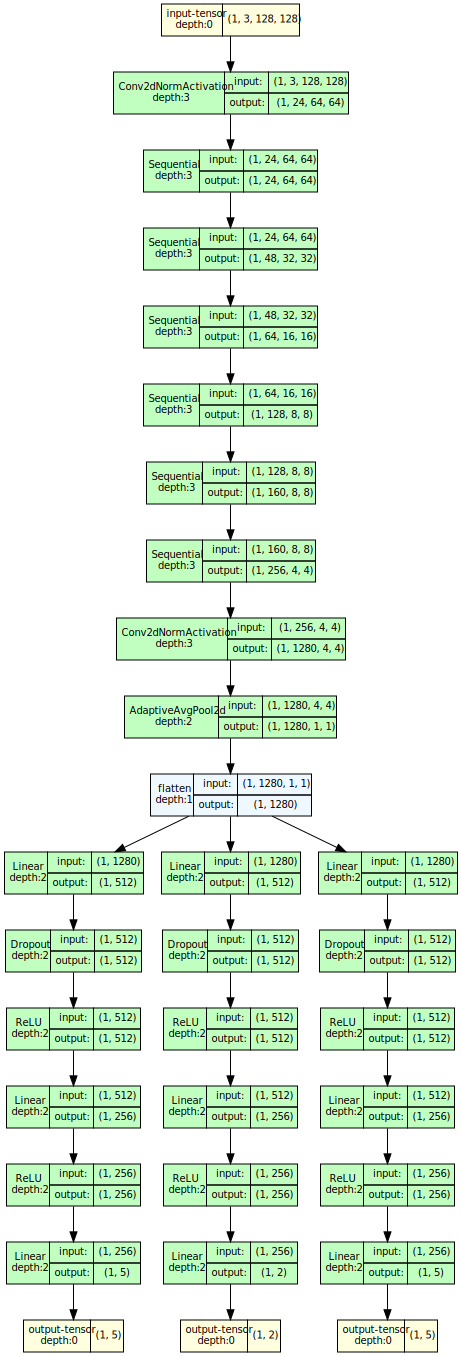

In [77]:
from torchview import draw_graph

model_graph = draw_graph(multi_task_model, input_size=(1, 3, 128, 128), 
                         device=device, roll=True, save_graph=True)

# Save the graph as a PNG image
model_graph.visual_graph.render(filename="multi_task_model", format="png")
model_graph.visual_graph

In [78]:
from timeit import default_timer as timer

start_time = timer()

model_results = train(model=multi_task_model, train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader, optimizer=optimizer, 
                      age_loss_fn=age_loss_fn, gender_loss_fn=gender_loss_fn, 
                      emotion_loss_fn=emotion_loss_fn, epochs=EPOCHS)

end_time = timer()
print(f'Total Training Time: {end_time - start_time:.3f} seconds')


Epoch 1/7
Train Loss: 0.8190 | Train Acc: 0.6562
Test Loss: 0.5519 | Test Acc: 0.7789
Train Overall Accuracy: {'Age Acc': 0.5723, 'Gender Acc': 0.8594, 'Emotion Acc': 0.5368}
Test Overall Accuracy: {'Age Acc': 0.7175, 'Gender Acc': 0.9397, 'Emotion Acc': 0.6794}

Epoch 2/7
Train Loss: 0.4971 | Train Acc: 0.8029
Test Loss: 0.4746 | Test Acc: 0.8024
Train Overall Accuracy: {'Age Acc': 0.7266, 'Gender Acc': 0.9362, 'Emotion Acc': 0.7459}
Test Overall Accuracy: {'Age Acc': 0.7047, 'Gender Acc': 0.9443, 'Emotion Acc': 0.7581}

Epoch 3/7
Train Loss: 0.3963 | Train Acc: 0.8441
Test Loss: 0.4055 | Test Acc: 0.8385
Train Overall Accuracy: {'Age Acc': 0.7749, 'Gender Acc': 0.9498, 'Emotion Acc': 0.8077}
Test Overall Accuracy: {'Age Acc': 0.7805, 'Gender Acc': 0.9522, 'Emotion Acc': 0.7829}

Epoch 4/7
Train Loss: 0.3253 | Train Acc: 0.8731
Test Loss: 0.4124 | Test Acc: 0.8457
Train Overall Accuracy: {'Age Acc': 0.8053, 'Gender Acc': 0.9652, 'Emotion Acc': 0.8487}
Test Overall Accuracy: {'Age Acc

## 8. Model Training Results

In [79]:
def plot_model_results(results):
    """
    Plots training and testing loss and accuracy curves for each heads.
    """

    # Extracts all information
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    train_acc = results['train_acc']
    test_acc = results['test_acc']

    train_age_acc = [accuracy['Age Acc'] for accuracy in results['train_overall_acc']]
    test_age_acc = [accuracy['Age Acc'] for accuracy in results['test_overall_acc']]

    train_gender_acc = [accuracy['Gender Acc'] for accuracy in results['train_overall_acc']]
    test_gender_acc = [accuracy['Gender Acc'] for accuracy in results['test_overall_acc']]

    train_emotion_acc = [accuracy['Emotion Acc'] for accuracy in results['train_overall_acc']]
    test_emotion_acc = [accuracy['Emotion Acc'] for accuracy in results['test_overall_acc']]

    epochs = range(len(train_loss))
    
    # Plot Loss
    plt.figure(figsize=(18, 9))
    plt.subplot(2, 3, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Overall Accuracy
    plt.subplot(2, 3, 2)
    plt.plot(epochs, train_acc, label='Train Overall Accuracy')
    plt.plot(epochs, test_acc, label='Test Overall Accuracy')
    plt.title('Overall Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Age Accuracy
    plt.subplot(2, 3, 3)
    plt.plot(epochs, train_age_acc, label='Train Age Accuracy')
    plt.plot(epochs, test_age_acc, label='Test Age Accuracy')
    plt.title('Age Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Gender Accuracy
    plt.subplot(2, 3, 4)
    plt.plot(epochs, train_gender_acc, label='Train Gender Accuracy')
    plt.plot(epochs, test_gender_acc, label='Test Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot Emotion Accuracy
    plt.subplot(2, 3, 5)
    plt.plot(epochs, train_emotion_acc, label='Train Emotion Accuracy')
    plt.plot(epochs, test_emotion_acc, label='Test Emotion Accuracy')
    plt.title('Emotion Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.savefig('model_results.png')
    plt.show()

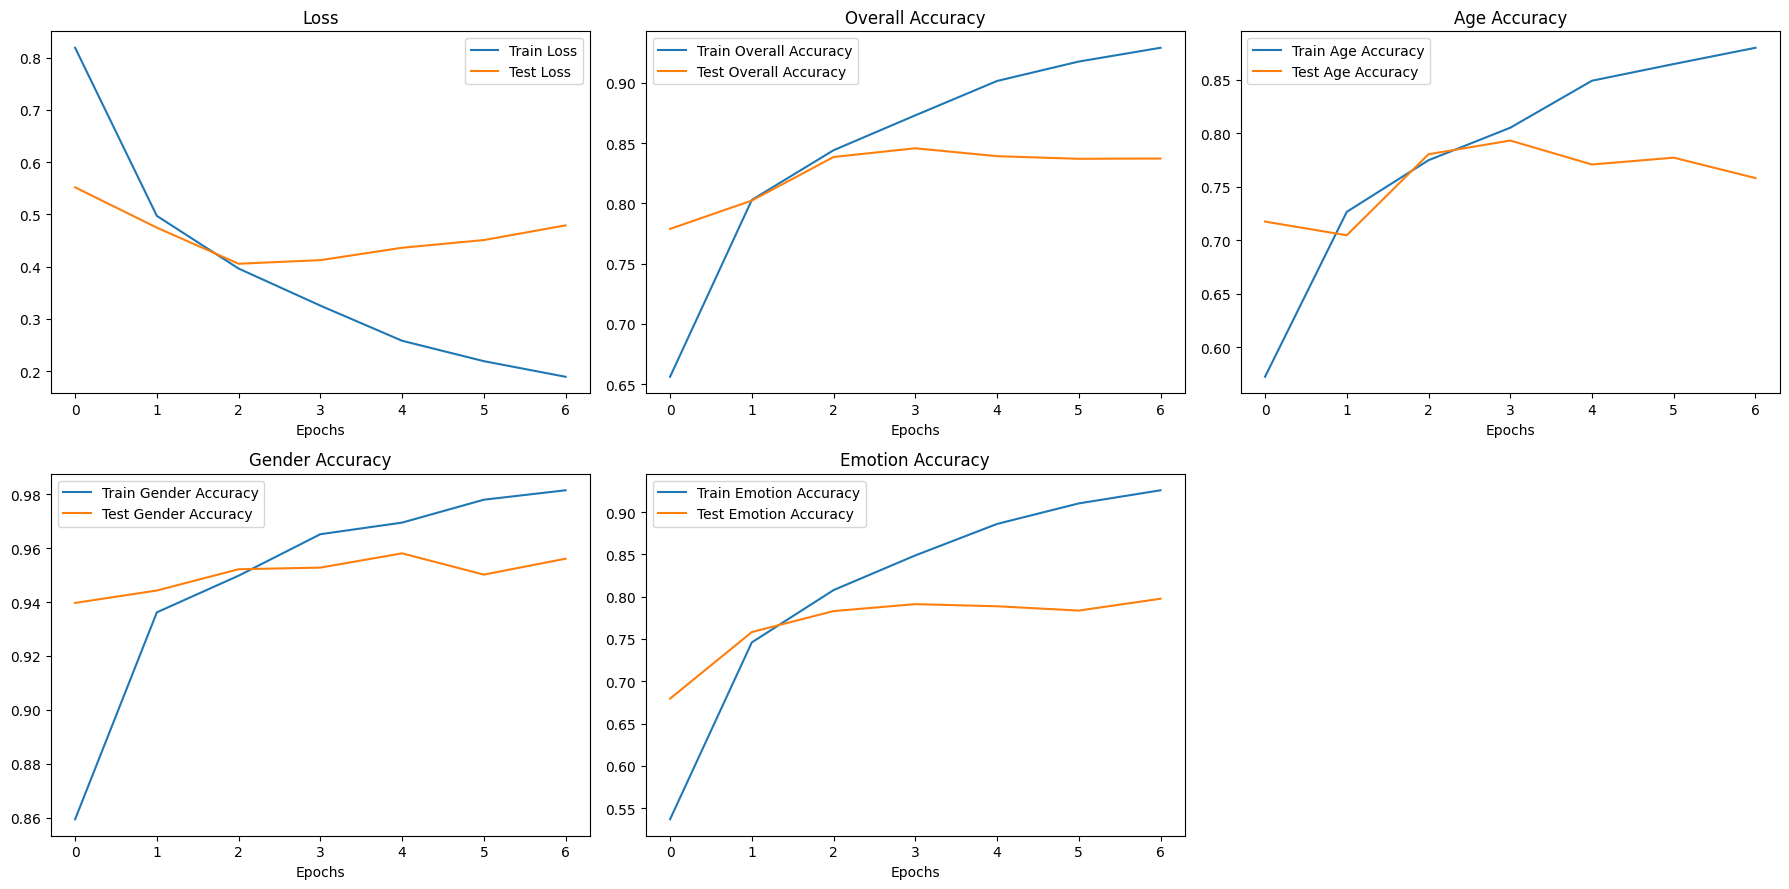

In [80]:
plot_model_results(results=model_results)

## 9. Model Evaluation

In [81]:
def predict_images(model, dataloader, device=device):

    """
    Perform prediction.

    Parameters:
        model: PyTorch multi-task model.
        dataloader: DataLoader for test data.
        age_loss_fn, gender_loss_fn, emotion_loss_fn: Loss functions for all tasks.
        device: Device for computation (e.g., "cpu" or "cuda").

        
    """
    age_pred_classes, age_true_classes = [], []
    gender_pred_classes, gender_true_classes = [], []
    emotion_pred_classes, emotion_true_classes = [], []

    model.eval()

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            age_pred, gender_pred, emotion_pred = model(X)

            # Age
            age_pred_class = age_pred.argmax(dim=1).tolist()
            age_true_class = y[:, 0].tolist()
            age_pred_classes.extend(age_pred_class)
            age_true_classes.extend(age_true_class)

            # Gender
            gender_pred_class = gender_pred.argmax(dim=1).tolist()
            gender_true_class = y[:, 1].tolist()
            gender_pred_classes.extend(gender_pred_class)
            gender_true_classes.extend(gender_true_class)

            # Emotion 
            emotion_pred_class = emotion_pred.argmax(dim=1).tolist()
            emotion_true_class = y[:, 2].tolist()
            emotion_pred_classes.extend(emotion_pred_class)
            emotion_true_classes.extend(emotion_true_class)

        results = {
            "Age": {'pred': age_pred_classes, 'true': age_true_classes},
            "Gender": {'pred': gender_pred_classes, 'true': gender_true_classes},
            "Emotion": {'pred': emotion_pred_classes, 'true': emotion_true_classes}
        }

        return results

In [82]:
eval_results = predict_images(model=multi_task_model, dataloader=test_dataloader)

In [83]:
from sklearn.metrics import classification_report

def classification_report_task(name, task_labels, eval_results):
    valid_indices = [i for i, value in enumerate(eval_results[name]['true']) if value != -1]
    true = [eval_results[name]['true'][i] for i in valid_indices]
    pred = [eval_results[name]['pred'][i] for i in valid_indices]

    report = classification_report(y_true=true, y_pred=pred, target_names=task_labels)
    print(f"\n🔹 Classification Report for {name} Task:")
    print(report)

In [84]:
age_labels, gender_labels, emotion_labels

(['Baby', 'Child', 'Teen', 'Adult', 'Elderly'],
 ['woman', 'man'],
 ['Surprise', 'Angry', 'Happy', 'Sad', 'Neutral'])

In [85]:
classification_report_task(name="Age", eval_results=eval_results, task_labels=age_labels)


🔹 Classification Report for Age Task:
              precision    recall  f1-score   support

        Baby       0.87      0.94      0.91       260
       Child       0.71      0.74      0.72       264
        Teen       0.56      0.62      0.59       183
       Adult       0.78      0.57      0.66       266
     Elderly       0.81      0.88      0.84       280

    accuracy                           0.76      1253
   macro avg       0.75      0.75      0.74      1253
weighted avg       0.76      0.76      0.75      1253



In [86]:
classification_report_task(name="Gender", eval_results=eval_results, task_labels=gender_labels)


🔹 Classification Report for Gender Task:
              precision    recall  f1-score   support

       woman       0.95      0.97      0.96       789
         man       0.97      0.94      0.95       737

    accuracy                           0.96      1526
   macro avg       0.96      0.96      0.96      1526
weighted avg       0.96      0.96      0.96      1526



In [87]:
classification_report_task(name="Emotion", eval_results=eval_results, task_labels=emotion_labels)


🔹 Classification Report for Emotion Task:
              precision    recall  f1-score   support

    Surprise       0.86      0.83      0.85       314
       Angry       0.87      0.84      0.85       301
       Happy       0.85      0.92      0.89       307
         Sad       0.76      0.65      0.70       324
     Neutral       0.67      0.76      0.71       329

    accuracy                           0.80      1575
   macro avg       0.80      0.80      0.80      1575
weighted avg       0.80      0.80      0.80      1575



## 10. Prediction on Real Unseen Images

In [88]:
!pip install torchvision

In [89]:
import torchvision

def real_image_prediction(model: torch.nn.Module, image_path: str, 
                    age_names, emotion_names, gender_names, 
                    transform=None, device=device):
    
    target_image = torchvision.io.read_image(image_path).type(torch.float32) / 255

    if transform:
        target_image = transform(target_image)
        
    model.to(device)
    model.eval()

    with torch.inference_mode():
        target_image = target_image.unsqueeze(0)
        results = model(target_image.to(device))

    age_probs = torch.softmax(results[0], dim=1)
    gender_probs = torch.softmax(results[1], dim=1)
    emotion_probs = torch.softmax(results[2], dim=1)
    
    age_labels = torch.argmax(age_probs, dim=1)
    gender_labels = torch.argmax(gender_probs, dim=1)
    emotion_labels = torch.argmax(emotion_probs, dim=1)

    age_class = age_names[age_labels]
    gender_class = gender_names[gender_labels]
    emotion_class = emotion_names[emotion_labels]

    results = {
        'Target Image': target_image,
        'Age': {'class': age_class, 'prob': age_probs.max()},
        'Gender': {'class': gender_class, 'prob': gender_probs.max()},
        'Emotion': {'class': emotion_class, 'prob': emotion_probs.max()}
    }

    return results

In [90]:
str(test_combined['file_path'][35])

'/kaggle/input/facial-emotion-dataset/facial_emotion_dataset/dataset/Surprise/cropped_emotions.100003~12fffff.png'

In [91]:
def plot_predicted_image(results):

    target_image = results['Target Image']
    
    age_class = results['Age']['class']
    gender_class = results['Gender']['class']
    emotion_class = results['Emotion']['class']

    age_prob = results['Age']['prob']
    gender_prob = results['Gender']['prob']
    emotion_prob = results['Emotion']['prob'] 
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0))

    title = f"Age Pred: {age_class} | Age Prob: {age_prob.max():.3f} \nGender Pred: {gender_class} | Gender Prob: {gender_prob.max():.3f} \nEmotion Pred: {emotion_class} | Emotion Prob: {emotion_prob.max():.3f}"
    plt.title(title)
    plt.axis(False)
    plt.savefig("prediction_sample.png")

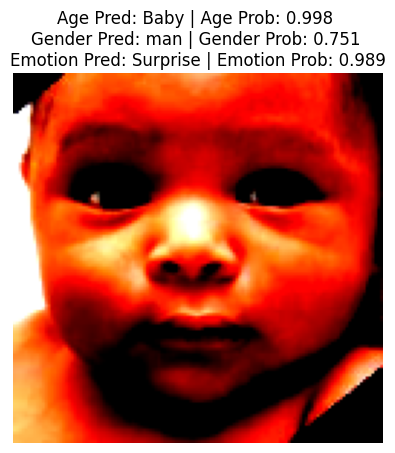

In [92]:
prediction_result = real_image_prediction(model=multi_task_model,age_names=age_labels, emotion_names=emotion_labels, gender_names=gender_labels,
                device=device, transform=custom_transforms, image_path=str(test_combined['file_path'][17]))

plot_predicted_image(results=prediction_result)

## 11. Edge Deployment

In [93]:
torch.save(multi_task_model.state_dict(), "age_gender_emotion_classifier.pt")

In [94]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

import torch
from torchinfo import summary

# Define model path
multi_task_model_path = "/kaggle/working/age_gender_emotion_classifier.pt"

# Initialize a new model instance (same architecture as the saved model)
my_model = MultiTaskEfficientNetV2(
    input_shape=1280, hidden_shape=512, 
    num_age_classes=NUM_AGE_BINS, 
    num_gender_classes=NUM_GENDERS, 
    num_emotion_classes=NUM_EMOTIONS
).to("cpu")

# Load only the weights (state_dict)
state_dict = torch.load(multi_task_model_path, map_location="cpu", weights_only=True)
my_model.load_state_dict(state_dict)  # Load weights into the model

# Set model to evaluation mode
my_model.eval()

# Create a dummy input for testing
dummy_input = torch.zeros(1, 3, 128, 128).to("cpu")  # Match training input shape

# Print model summary
summary(my_model, input_data=dummy_input)

Layer (type:depth-idx)                                       Output Shape              Param #
MultiTaskEfficientNetV2                                      [1, 5]                    --
├─Sequential: 1-1                                            [1, 1280, 1, 1]           --
│    └─Sequential: 2-1                                       [1, 1280, 4, 4]           --
│    │    └─Conv2dNormActivation: 3-1                        [1, 24, 64, 64]           696
│    │    └─Sequential: 3-2                                  [1, 24, 64, 64]           10,464
│    │    └─Sequential: 3-3                                  [1, 48, 32, 32]           303,552
│    │    └─Sequential: 3-4                                  [1, 64, 16, 16]           589,184
│    │    └─Sequential: 3-5                                  [1, 128, 8, 8]            917,680
│    │    └─Sequential: 3-6                                  [1, 160, 8, 8]            3,463,840
│    │    └─Sequential: 3-7                                  [1, 256

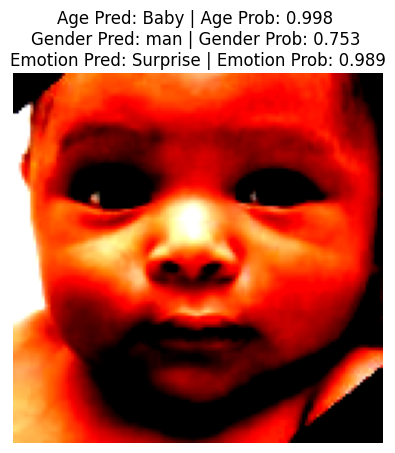

In [95]:
import torch

# Move model to CPU and evaluation mode
my_model.to("cpu")
my_model.eval()

# Apply dynamic quantization to Linear layers only
quantized_model = torch.quantization.quantize_dynamic(
    my_model, 
    {torch.nn.Linear},  # Quantize only fully connected layers
    dtype=torch.qint8   # Convert weights to 8-bit integers
).to("cpu").eval()

# Create a dummy input for testing
dummy_input = torch.zeros(1, 3, 128, 128).to("cpu")  # Match training input shape

# Print model summary
summary(quantized_model, input_data=dummy_input)

# Convert the quantized model to TorchScript
scripted_model = torch.jit.script(quantized_model)

# Save the TorchScript model
scripted_model.save("age_gender_emotion_classifier.ptl")


# Run inference with an image
prediction_result = real_image_prediction(
    model=scripted_model, 
    age_names=age_labels, 
    emotion_names=emotion_labels, 
    gender_names=gender_labels,
    device="cpu",  # Ensure inference is on CPU
    transform=custom_transforms, 
    image_path=str(test_combined['file_path'][17])
)

# Visualize results
plot_predicted_image(results=prediction_result)